In [350]:
%matplotlib inline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from biopandas.pdb import PandasPDB as PandasPDB
from IPython.display import display


from IPython.display import display

In [351]:
protein_1 = PandasPDB().read_pdb("./2dor.pdb")

In [352]:
hetatms = protein_1.df["HETATM"]

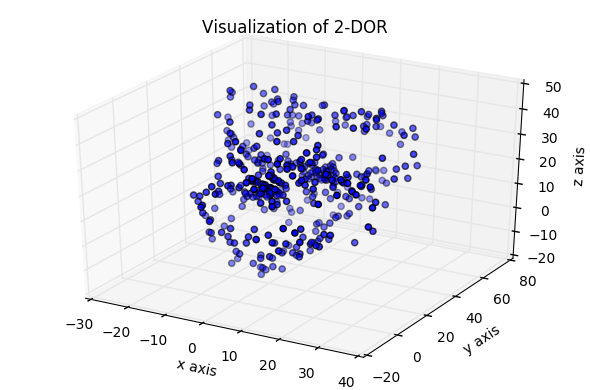

In [379]:
# display the protein for kicks
x_vals = hetatms['x_coord']
y_vals = hetatms['y_coord']
z_vals = hetatms['z_coord']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_vals, y_vals, z_vals)

ax.set_xlabel("x axis")
ax.set_ylabel("y axis")
ax.set_zlabel("z axis")
ax.set_title("Visualization of 2-DOR")

plt.tight_layout()
plt.show()


In [354]:
def make_distance_comparator(origin):
    """Creates a function to that determines the distance between two heatms in the dataframe
    :param origin pandas.core.series.Series: the origin point, specified as a x, y, z, tuple
    """
    keys = ["x_coord", "y_coord", "z_coord"]
    x_o, y_o, z_o = origin[keys]
    
    def distance_comparator(point):
        """Returns the Euclidean Distance between two points in 3D space
        :param point pandas.core.Series.Series: the point we want to get the distance for
        """
        x, y, z = point[keys]
        return np.sqrt((x - x_o) **2 + (y - y_o) ** 2 + (z - z_o) ** 2)
    
    return distance_comparator

In [375]:
# quick test of above closure
initial_point = hetatms.iloc[2]
test_point = hetatms.iloc[1]
distance_func = make_distance_comparator(initial_point)
distance_func(test_point)

1.2126446305492802

In [365]:
# Core loop to get relevant data

neighbors = []

coords = hetatms[["x_coord", "y_coord", "z_coord"]]

for row_idx in range(len(coords)):
    atom = coords.iloc[row_idx]
    distance_func = make_distance_comparator(atom)
    
    # reduce the dataframe of x,y,z to distance from the selected atom
    distance_from_atom_df = hetatms.apply(distance_func, axis=1)
    
    # sort by distance
    sorted_distance = np.sort(distance_from_atom_df)
    sorted_distance = sorted_distance[1:]
    
    # get the original indices from the dataframe after sorting to index into hetratm dataframe
    sorted_indices = np.argsort(distance_from_atom_df)
    sorted_indices = sorted_indices[1:]
    
    # creating a copy so the pandas shuts up and we don't have any issues
    # with accidentally modifying the original hetratm dataframe
    key_hetatm_data = hetatms.iloc[sorted_indices].copy()
    key_hetatm_data['distance'] = sorted_distance
    
    # drop the col telling us we're dealing with HETATM
    key_hetatm_data.drop("record_name", axis=1, inplace=True)
    #move the atom_name col to the front for writing it to file
    cols = ["atom_name"] + [col for col in key_hetatm_data if col != "atom_name"]
    key_hetatm_data = key_hetatm_data[cols]
    # add this to our results list
    neighbors.append((hetatms["atom_number"].iloc[row_idx], key_hetatm_data))

In [373]:
results = {}
results["pdb_name"] = "2DOR"
results["neighbors"] = neighbors

In [378]:
with open("2dor.txt", "w") as f:
    f.write("PDB Name: {}\n".format(results["pdb_name"]))
    f.write("Neighbors:\n")
    
    count = 1
    for key_hetratm_number, neighbors_df in results["neighbors"]:
        f.write("\tKEY HETRATM {}: {}\n\t{}\n".format(count, key_hetratm_number, neighbors_df.to_string(index=False)))
        count += 1
